# Segmenting and Clustering Neighborhoods in New York City

## Introduction

In this lab, you will learn how to convert addresses into their equivalent latitude and longitude values. Also, you will use the Foursquare API to explore neighborhoods in New York City. You will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. You will use the *k*-means clustering algorithm to complete this task. Finally, you will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [64]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

In [65]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [128]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [129]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [68]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [130]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [131]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [71]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [132]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [133]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [134]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [135]:
ny_borough = neighborhoods[['Borough','Neighborhood']]
ny_borough.head()

,Borough,Neighborhood
0,Bronx,Wakefield
1,Bronx,Co-op City
2,Bronx,Eastchester
3,Bronx,Fieldston
4,Bronx,Riverdale


In [136]:
import matplotlib.pyplot as plt
ny_borough = neighborhoods[['Borough','Neighborhood']]
ny_borough_grouped = ny_borough.groupby('Borough')['Neighborhood'].count()

ny_borough_grouped


Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64

Text(0.5, 1.0, 'New York City Borough and  Neighborhoods')

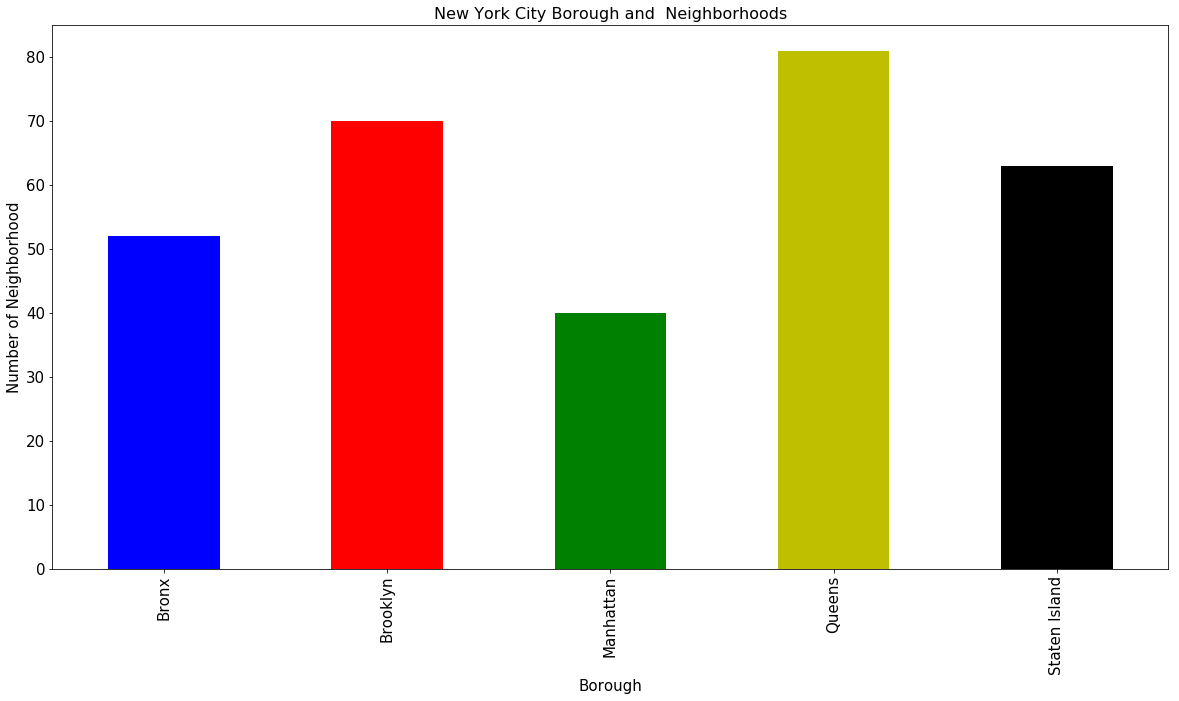

In [92]:


ax= ny_borough_grouped.plot(kind="bar" , fontsize=15, figsize=(20,10), color=['b', 'r', 'g', 'y', 'k'] )
ax.set_ylabel("Number of Neighborhood",fontsize=15 )
ax.set_xlabel("Borough",fontsize=15 )
ax.set_title("New York City Borough and  Neighborhoods",fontsize=16 )



#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [137]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [138]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [139]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)

brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


Let's get the geographical coordinates of Manhattan.

In [140]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


As we did with all of New York City, let's visualizat Brooklyn the neighborhoods in it.

In [81]:
# create map of Brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [141]:


CLIENT_ID = 'JOC4O0ASANGEGA2ZKCUWXNTV2ETWIASVYBCEE4DQ2I2EJ1FX' # your Foursquare ID
CLIENT_SECRET = '2XG00U2WO5H2YKN0QNGZE0DPAQ5SDY3TN5UEHJUJ52HIWXO1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JOC4O0ASANGEGA2ZKCUWXNTV2ETWIASVYBCEE4DQ2I2EJ1FX
CLIENT_SECRET:2XG00U2WO5H2YKN0QNGZE0DPAQ5SDY3TN5UEHJUJ52HIWXO1


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [142]:
brooklyn_data.loc[0, 'Neighborhood']

'Bay Ridge'

Get the neighborhood's latitude and longitude values.

In [143]:
neighborhood_latitude = brooklyn_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = brooklyn_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = brooklyn_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bay Ridge are 40.625801065010656, -74.03062069353813.


#### Now, let's get the top 100 venues that are in Bay Ridge within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [144]:
search_query = 'Crown Heights,NY'
radius=500
LIMIT=100
# type your answer here
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url




'https://api.foursquare.com/v2/venues/search?client_id=JOC4O0ASANGEGA2ZKCUWXNTV2ETWIASVYBCEE4DQ2I2EJ1FX&client_secret=2XG00U2WO5H2YKN0QNGZE0DPAQ5SDY3TN5UEHJUJ52HIWXO1&ll=40.6501038,-73.9495823&v=20180605&query=Crown Heights,NY&radius=500&limit=100'

Double-click __here__ for the solution.
<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 

Send the GET request and examine the resutls

In [145]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ce9bb38f594df57e9baab27'},
 'response': {'venues': [{'id': '59d5ef76d0a14960755968c1',
    'name': 'Eddie and Sons Locksmith - Brooklyn NY',
    'location': {'address': 'Serving area',
     'lat': 40.65000609742766,
     'lng': -73.94925355911255,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.65000609742766,
       'lng': -73.94925355911255}],
     'distance': 29,
     'postalCode': '11230',
     'cc': 'US',
     'city': 'Brooklyn',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['Serving area',
      'Brooklyn, NY 11230',
      'United States']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b1e',
      'name': 'Locksmith',
      'pluralName': 'Locksmiths',
      'shortName': 'Locksmith',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/default_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '479915544'},
    'referralId': 'v-1558821688',
    'hasP

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [146]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [147]:
#venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(results['response']['venues']) # flatten JSON
    
#nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
#filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng,categories
0,Eddie and Sons Locksmith - Brooklyn NY,"[{'id': '52f2ab2ebcbc57f1066b8b1e', 'name': 'L...",40.650006,-73.949254,Locksmith


And how many venues were returned by Foursquare?

In [43]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

1 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore Neighborhoods in Brooklyn

#### Let's create a function to repeat the same process to all the neighborhoods in Brooklyn

In [148]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [149]:
# type your answer here

brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )



Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [150]:
print(brooklyn_venues.shape)
brooklyn_venues.head()

(2838, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.623348,-74.031082,Pizza Place


Let's check how many venues were returned for each neighborhood

In [91]:
brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,46,46,46,46,46,46
Bay Ridge,86,86,86,86,86,86
Bedford Stuyvesant,27,27,27,27,27,27
Bensonhurst,35,35,35,35,35,35
Bergen Beach,7,7,7,7,7,7
Boerum Hill,87,87,87,87,87,87
Borough Park,19,19,19,19,19,19
Brighton Beach,43,43,43,43,43,43
Broadway Junction,14,14,14,14,14,14


#### Let's find out how many unique categories can be curated from all the returned venues

In [151]:
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 289 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [152]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Yoga Studio,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Book

And let's examine the new dataframe size.

In [94]:
brooklyn_onehot.shape

(2838, 289)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [153]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Book

#### Let's confirm the new size

In [122]:
brooklyn_grouped.shape

(70, 289)

# Let's print each neighborhood along with the top 5 most common venues

In [154]:
num_top_venues = 5

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                  venue  freq
0              Pharmacy  0.07
1    Chinese Restaurant  0.07
2            Kids Store  0.04
3       Bubble Tea Shop  0.04
4  Cantonese Restaurant  0.04


----Bay Ridge----
                venue  freq
0                 Spa  0.07
1  Italian Restaurant  0.06
2         Pizza Place  0.05
3          Bagel Shop  0.05
4    Greek Restaurant  0.03


----Bedford Stuyvesant----
           venue  freq
0    Coffee Shop  0.11
1           Café  0.07
2            Bar  0.07
3    Pizza Place  0.07
4  Deli / Bodega  0.07


----Bensonhurst----
                venue  freq
0         Pizza Place  0.09
1  Chinese Restaurant  0.09
2    Sushi Restaurant  0.06
3          Donut Shop  0.06
4      Ice Cream Shop  0.06


----Bergen Beach----
             venue  freq
0  Harbor / Marina  0.29
1       Donut Shop  0.14
2     Hockey Field  0.14
3       Playground  0.14
4   Baseball Field  0.14


----Boerum Hill----
            venue  freq
0     Coffee Shop  0.05
1    Dance St

                venue  freq
0  Athletics & Sports  0.11
1    Basketball Court  0.11
2       Deli / Bodega  0.11
3      Ice Cream Shop  0.11
4      Baseball Field  0.11


----Midwood----
              venue  freq
0       Pizza Place  0.33
1  Video Game Store  0.08
2          Pharmacy  0.08
3            Bakery  0.08
4        Bagel Shop  0.08


----Mill Basin----
                 venue  freq
0          Pizza Place  0.11
1   Chinese Restaurant  0.08
2       Cosmetics Shop  0.05
3     Sushi Restaurant  0.05
4  Japanese Restaurant  0.05


----Mill Island----
               venue  freq
0  Other Repair Shop  0.25
1               Pool  0.25
2               Lake  0.25
3               Food  0.25
4        Yoga Studio  0.00


----New Lots----
                       venue  freq
0                Pizza Place  0.14
1              Grocery Store  0.10
2              Deli / Bodega  0.10
3         Spanish Restaurant  0.05
4  Latin American Restaurant  0.05


----North Side----
                 venue  freq


#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [155]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [156]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted.head()

neighborhoods_venues_sorted.set_index("Neighborhood").head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,
Bath Beach,Pharmacy,Chinese Restaurant,Kids Store,Sushi Restaurant,Cantonese Restaurant,Fast Food Restaurant,Bubble Tea Shop,Italian Restaurant,Gas Station,Liquor Store
Bay Ridge,Spa,Italian Restaurant,Bagel Shop,Pizza Place,Thai Restaurant,Greek Restaurant,American Restaurant,Bar,Sandwich Place,Playground
Bedford Stuyvesant,Coffee Shop,Bar,Pizza Place,Deli / Bodega,Café,Basketball Court,Juice Bar,Bagel Shop,BBQ Joint,Thrift / Vintage Store
Bensonhurst,Chinese Restaurant,Pizza Place,Donut Shop,Sushi Restaurant,Ice Cream Shop,Grocery Store,Dumpling Restaurant,Noodle House,Supermarket,Pet Store
Bergen Beach,Harbor / Marina,Donut Shop,Athletics & Sports,Baseball Field,Playground,Hockey Field,Farm,Farmers Market,Fast Food Restaurant,Field


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [157]:
# set number of clusters
kclusters = 5

brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 4, 0, 1, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [158]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

brooklyn_merged = brooklyn_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,1,Spa,Italian Restaurant,Bagel Shop,Pizza Place,Thai Restaurant,Greek Restaurant,American Restaurant,Bar,Sandwich Place,Playground
1,Brooklyn,Bensonhurst,40.611009,-73.995180,4,Chinese Restaurant,Pizza Place,Donut Shop,Sushi Restaurant,Ice Cream Shop,Grocery Store,Dumpling Restaurant,Noodle House,Supermarket,Pet Store
2,Brooklyn,Sunset Park,40.645103,-74.010316,1,Mexican Restaurant,Bakery,Latin American Restaurant,Bank,Pizza Place,Mobile Phone Shop,Pharmacy,Gym,Donut Shop,Record Shop
3,Brooklyn,Greenpoint,40.730201,-73.954241,1,Bar,Pizza Place,Coffee Shop,Café,Cocktail Bar,Yoga Studio,Record Shop,Mexican Restaurant,French Restaurant,Furniture / Home Store
4,Brooklyn,Gravesend,40.595260,-73.973471,4,Pizza Place,Chinese Restaurant,Martial Arts Dojo,Lounge,Italian Restaurant,Bus Station,Bakery,Diner,Gym,Music Store


Finally, let's visualize the resulting clusters

In [159]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [78]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,Bergen Beach,Harbor / Marina,Donut Shop,Athletics & Sports,Baseball Field,Playground,Hockey Field,Farm,Farmers Market,Fast Food Restaurant,Field


#### Cluster 2

In [79]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Spa,Italian Restaurant,Bagel Shop,Pizza Place,Thai Restaurant,Greek Restaurant,American Restaurant,Bar,Sandwich Place,Playground
2,Sunset Park,Mexican Restaurant,Bakery,Latin American Restaurant,Bank,Pizza Place,Mobile Phone Shop,Pharmacy,Gym,Donut Shop,Record Shop
3,Greenpoint,Bar,Pizza Place,Coffee Shop,Café,Cocktail Bar,Yoga Studio,Record Shop,Mexican Restaurant,French Restaurant,Furniture / Home Store
5,Brighton Beach,Beach,Restaurant,Eastern European Restaurant,Gourmet Shop,Fast Food Restaurant,Russian Restaurant,Sushi Restaurant,Bank,Mobile Phone Shop,Convenience Store
6,Sheepshead Bay,Dessert Shop,Turkish Restaurant,Ice Cream Shop,Sandwich Place,Yoga Studio,Café,Russian Restaurant,Restaurant,Creperie,Department Store
8,Flatbush,Deli / Bodega,Coffee Shop,Caribbean Restaurant,Mexican Restaurant,Juice Bar,Pizza Place,Pharmacy,Donut Shop,Sandwich Place,Chinese Restaurant
10,East Flatbush,Chinese Restaurant,Deli / Bodega,Pharmacy,Caribbean Restaurant,Bakery,Park,Hardware Store,Supermarket,Moving Target,Department Store
11,Kensington,Sandwich Place,Thai Restaurant,Grocery Store,Pharmacy,Restaurant,Pizza Place,Ice Cream Shop,Lingerie Store,Taco Place,Furniture / Home Store
12,Windsor Terrace,Diner,Plaza,Park,Food Truck,Coffee Shop,Bagel Shop,Chinese Restaurant,Beer Store,Sushi Restaurant,American Restaurant
13,Prospect Heights,Bar,Mexican Restaurant,Cocktail Bar,Wine Shop,Gourmet Shop,Bakery,Thai Restaurant,Southern / Soul Food Restaurant,New American Restaurant,Diner


#### Cluster 3

In [80]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Mill Island,Other Repair Shop,Pool,Lake,Food,Filipino Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


#### Cluster 4

In [81]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Canarsie,Chinese Restaurant,Bus Line,Caribbean Restaurant,Asian Restaurant,Gym,Food Court,Food & Drink Shop,Food,Flower Shop,Farm
59,Paerdegat Basin,Chinese Restaurant,Asian Restaurant,Gym,Bus Line,Food,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop


#### Cluster 5

In [82]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 4, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bensonhurst,Chinese Restaurant,Pizza Place,Donut Shop,Sushi Restaurant,Ice Cream Shop,Grocery Store,Dumpling Restaurant,Noodle House,Supermarket,Pet Store
4,Gravesend,Pizza Place,Chinese Restaurant,Martial Arts Dojo,Lounge,Italian Restaurant,Bus Station,Bakery,Diner,Gym,Music Store
7,Manhattan Terrace,Pizza Place,Ice Cream Shop,Bus Station,Convenience Store,Mobile Phone Shop,Burger Joint,Café,Steakhouse,Nightclub,Falafel Restaurant
9,Crown Heights,Pizza Place,Grocery Store,Museum,Café,Coffee Shop,Candy Store,Supermarket,Salon / Barbershop,Burger Joint,Bakery
27,Starrett City,Women's Store,Pharmacy,Liquor Store,Supermarket,Shoe Store,Donut Shop,Shopping Mall,Caribbean Restaurant,Intersection,Bus Station
31,Manhattan Beach,Bus Stop,Café,Ice Cream Shop,Sandwich Place,Beach,Playground,Pizza Place,Food,Fish & Chips Shop,Fast Food Restaurant
35,Dyker Heights,Dance Studio,Plaza,Golf Course,Grocery Store,Bagel Shop,Burger Joint,Hot Dog Joint,Diner,Farm,Food Stand
37,Marine Park,Baseball Field,Pizza Place,Gym,Athletics & Sports,Cosmetics Shop,Basketball Court,Ice Cream Shop,Deli / Bodega,Soccer Field,Food Stand
39,Sea Gate,Spa,Beach,Optical Shop,Bus Station,Home Service,Fish Market,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
46,Midwood,Pizza Place,Ice Cream Shop,Video Game Store,Bakery,Bagel Shop,Candy Store,Convenience Store,Pharmacy,Italian Restaurant,Flower Shop


### Thank you for completing this lab!

This notebook was created by [Alex Aklson](https://www.linkedin.com/in/aklson/) and [Polong Lin](https://www.linkedin.com/in/polonglin/). I hope you found this lab interesting and educational. Feel free to contact us if you have any questions!

This notebook is part of a course on **Coursera** called *Applied Data Science Capstone*. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DP0701EN_Coursera_Week3_LAB2).

<hr>

Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).